In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Todd Ideas,176.438893,11.762593,15
Network Mapping,203.991511,40.798302,5
Powershell,480.681334,48.068133,10
Terraform,532.602604,21.304104,25
FSLogix,1084.967063,45.206961,24
Email Auth and Security,1131.548195,87.042169,13
Azure Functions + Visual Studio,1165.173522,83.226680,14
Audit Report Tracker (Sharepoint List),1166.639121,72.914945,16
OData,1357.670629,90.511375,15
DNS,1367.682056,85.480129,16


# Histogram

40789.87


<Axes: >

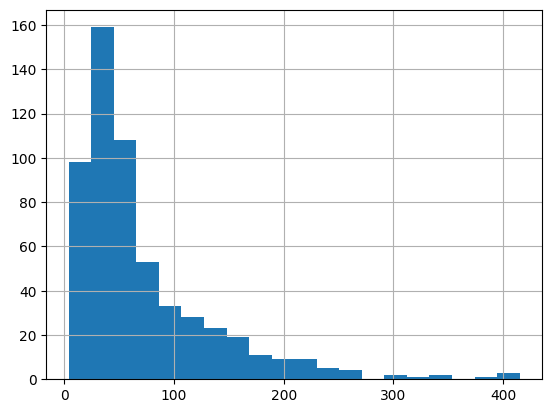

In [4]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [14]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [16]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n
existing_cards['age'] *= -1
existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 568


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
126,IW Migration,Database Diagrams (SSMS)\nGraphical representa...,caf9c5ce7f5521a8a00e9d099914a6a7,-298.504702,107.521130,298.504702,2150.422590,0.006819,0,0
129,IW Migration,Functions (User-Defined Functions) (SQL Server...,668adfc065c3a61f0b42c4c8a10594dc,-198.706673,107.521130,298.504702,2150.422590,0.006819,3,0
137,IW Migration,Property Sheets (Access)\nPanels that display ...,d9399e2ff0774171342b58e96e22e26f,-110.964327,107.521130,298.504702,2150.422590,0.006819,6,0
144,IW Migration,Template Explorer (SSMS)\nA feature in SQL Ser...,5b4f6badddb89919760ebc428cd9fb8d,-75.804938,107.521130,298.504702,2150.422590,0.006819,9,0
313,IW Migration,Security (SSMS)\nTools and configurations for ...,7649af2b59f7ce112b4e9db83b703c39,-55.656601,107.521130,298.504702,2150.422590,0.006819,12,0
318,IW Migration,Syntax to find files that contain a substring....,b9fd931861c30f887477331850055373,-45.974620,107.521130,298.504702,2150.422590,0.006819,15,0
320,IW Migration,Refactoring and Normalization (Access/SQL Serv...,08890f3b4934c1888406c827168eab08,-40.053382,107.521130,298.504702,2150.422590,0.006819,18,0
236,JavaScript Concepts,You Don’t Know JS: A series of books by Kyle S...,15cac4aa4c24000c61abab2424f1d7b9,-63.008950,34.857535,63.008950,2474.885012,0.025122,0,0
238,JavaScript Concepts,NestJS: A progressive Node.js framework built ...,77adaf6b39ab2d2166e3e747005e7fc2,-50.331631,34.857535,63.008950,2474.885012,0.025122,3,0
426,JavaScript Concepts,Destructuring: Syntax for unpacking values fro...,cf45c67e3fe6d2cc720996005c958996,-45.451849,34.857535,63.008950,2474.885012,0.025122,6,0


In [17]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
126,IW Migration,Database Diagrams (SSMS)\nGraphical representa...,caf9c5ce7f5521a8a00e9d099914a6a7,-298.504702,107.521130,298.504702,2150.422590,0.006819,0,0
129,IW Migration,Functions (User-Defined Functions) (SQL Server...,668adfc065c3a61f0b42c4c8a10594dc,-198.706673,107.521130,298.504702,2150.422590,0.006819,3,0
137,IW Migration,Property Sheets (Access)\nPanels that display ...,d9399e2ff0774171342b58e96e22e26f,-110.964327,107.521130,298.504702,2150.422590,0.006819,6,0
144,IW Migration,Template Explorer (SSMS)\nA feature in SQL Ser...,5b4f6badddb89919760ebc428cd9fb8d,-75.804938,107.521130,298.504702,2150.422590,0.006819,9,0
313,IW Migration,Security (SSMS)\nTools and configurations for ...,7649af2b59f7ce112b4e9db83b703c39,-55.656601,107.521130,298.504702,2150.422590,0.006819,12,0
318,IW Migration,Syntax to find files that contain a substring....,b9fd931861c30f887477331850055373,-45.974620,107.521130,298.504702,2150.422590,0.006819,15,0
320,IW Migration,Refactoring and Normalization (Access/SQL Serv...,08890f3b4934c1888406c827168eab08,-40.053382,107.521130,298.504702,2150.422590,0.006819,18,0
236,JavaScript Concepts,You Don’t Know JS: A series of books by Kyle S...,15cac4aa4c24000c61abab2424f1d7b9,-63.008950,34.857535,63.008950,2474.885012,0.025122,0,0
238,JavaScript Concepts,NestJS: A progressive Node.js framework built ...,77adaf6b39ab2d2166e3e747005e7fc2,-50.331631,34.857535,63.008950,2474.885012,0.025122,3,0
426,JavaScript Concepts,Destructuring: Syntax for unpacking values fro...,cf45c67e3fe6d2cc720996005c958996,-45.451849,34.857535,63.008950,2474.885012,0.025122,6,0


In [18]:
existing_cards['age'].mean()

np.float64(-71.81315429363282)